# Churn-Reason Mining with Transformers + Prompted LLM Layer (Synthetic Data)

This notebook is **portfolio-safe**: it uses **synthetic call-note text** and open-source models.

It demonstrates two complementary approaches:

1) **Encoder Transformers** (embeddings + optional fine-tuned classifier)
   - Sentence embeddings for clustering / taxonomy discovery
   - Optional DistilBERT fine-tuning for scalable classification

2) **Prompted LLM Layer** (prompt engineering)
   - Few-shot prompting for **multi-label extraction**
   - Prompted **cluster summaries** and **executive bullets**
   - Structured outputs (JSON) + validation

> Notes  
> • Model downloads require internet access (Hugging Face).  
> • If you’re offline, you can still run synthetic data generation + TF-IDF baseline sections.


## 0) Install / environment

If running locally or Colab:

```bash
pip install -q pandas numpy scikit-learn matplotlib
pip install -q transformers datasets accelerate sentence-transformers
```

If your environment blocks downloads, use a cached model or skip prompted/fine-tuned sections.


### Imports and utilities
Load core libraries used throughout the notebook.
- `numpy/pandas`: data generation + manipulation
- `matplotlib`: visualization
- `sklearn`: evaluation utilities
- `RNG`: seeded random generator so results are reproducible


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

RNG = np.random.default_rng(42)


## 1) Synthetic call-note dataset

We emulate common churn-driver buckets and generate text with:
- anchor phrases per bucket
- device/platform mentions
- competitor mentions
- promo/billing confusion
- typos + filler words

This ensures the notebook can be shared publicly.


### Build a synthetic dataset
Define a churn-reason taxonomy and generate synthetic call-note snippets.
Key ideas:
- Each reason has anchor phrases (`SEEDS`) that emulate real call notes
- We inject noise (device mentions, filler words, mild typos) to avoid toy-perfect text
- We also add occasional multi-driver notes (e.g., pricing + tech) to better reflect reality


In [2]:
import re
from typing import Dict, List, Tuple

REASONS = [
    "APP_TECH",
    "PRICING_PROMO",
    "CONTENT_AUTH",
    "FREE_TRIAL",
    "COMPETITOR_LOYALTY",
]

REASON_DISPLAY = {
    "APP_TECH": "App Experience & Technical Issues",
    "PRICING_PROMO": "Pricing & Promotion Roll-off",
    "CONTENT_AUTH": "Content & Authentication Issues",
    "FREE_TRIAL": "Free-Trial Gamers",
    "COMPETITOR_LOYALTY": "Competitor Switch / Loyalty",
}

SEEDS: Dict[str, List[str]] = {
    "APP_TECH": [
        "app keeps freezing", "buffering nonstop", "audio out of sync",
        "crashes on my fire stick", "roku app won't load",
        "smart tv app is slow", "interface is confusing",
        "recordings not showing", "search is confusing",
    ],
    "PRICING_PROMO": [
        "price went up", "promo ended", "discount expired",
        "bill increased", "charged more than expected",
        "can't afford it", "too expensive", "thought it was $40",
    ],
    "CONTENT_AUTH": [
        "can't authenticate espn", "activation email never came",
        "disney login doesn't work", "missing channels",
        "can't watch nfl game", "content i want is not available",
    ],
    "FREE_TRIAL": [
        "just wanted the free trial", "only signed up for the trial",
        "forgot to cancel", "i didn't mean to pay",
        "never intended to keep it", "testing the service",
    ],
    "COMPETITOR_LOYALTY": [
        "going back to youtube tv", "switching back to yttv",
        "i prefer youtube tv interface", "hulu live works better",
        "fubo for sports", "bundle with my other services",
    ],
}

DEVICES = ["Roku", "Fire Stick", "Apple TV", "Smart TV", "iPhone", "Android", "Xbox"]
FILLERS = ["honestly", "basically", "like", "you know", "overall", "kinda"]
ACTIONS = ["canceling", "disconnecting", "ending service", "not renewing", "closing account"]

def add_noise(s: str) -> str:
    if RNG.random() < 0.25:
        s = s.replace("ing", "in").replace("can't", "cant")
    if RNG.random() < 0.35:
        s = f"{RNG.choice(FILLERS)} {s}"
    if RNG.random() < 0.20:
        s = s + f" on {RNG.choice(DEVICES)}"
    if RNG.random() < 0.15:
        s = s + f", {RNG.choice(ACTIONS)}."
    return s

def synth_row(reason: str) -> str:
    base = RNG.choice(SEEDS[reason])
    if RNG.random() < 0.18:
        other = RNG.choice([r for r in REASONS if r != reason])
        base = base + "; " + RNG.choice(SEEDS[other])
    return add_noise(base)

N = 9000
rows = []
for i in range(N):
    # random but stable-ish class mix (Dirichlet)
    mix = RNG.dirichlet([3, 3, 3, 2, 1])  # tweak concentration as you like
    r = RNG.choice(REASONS, p=mix)
    rows.append({"id": i+1, "text": synth_row(r), "label": r})

df = pd.DataFrame(rows)
df.head()


,id,text,label
0,1,"you know never intended to keep it, closing ac...",FREE_TRIAL
1,2,recordings not showing,APP_TECH
2,3,"overall interface is confusing, closing account.",APP_TECH
3,4,promo ended,PRICING_PROMO
4,5,search is confusing,APP_TECH


### Check class balance
Sanity-check that the synthetic dataset has a realistic class distribution.


In [3]:
df['label'].value_counts(normalize=True).round(3)

label
CONTENT_AUTH          0.262
PRICING_PROMO         0.250
APP_TECH              0.243
FREE_TRIAL            0.163
COMPETITOR_LOYALTY    0.083
Name: proportion, dtype: float64

## 2) Encoder transformer embeddings + clustering (optional)

This helps validate/adjust a taxonomy before labels are solid.


### Embed text with a transformer and cluster
Use a transformer encoder to convert each note into a dense embedding vector.
Then cluster embeddings to:
- validate the taxonomy (do clusters align with buckets?)
- surface sub-topics (more clusters than buckets)
This step is useful even when labels are limited.


In [4]:
from sklearn.cluster import KMeans

use_embeddings = True
embeddings = None

try:
    from sentence_transformers import SentenceTransformer
    emb_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = emb_model.encode(
        df["text"].tolist(),
        show_progress_bar=True,
        batch_size=128,
        normalize_embeddings=True
    )
except Exception as e:
    use_embeddings = False
    print("Embedding model unavailable. Skipping embeddings step.\n", repr(e))

if use_embeddings:
    k = 7
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    df["cluster"] = km.fit_predict(embeddings)
    display(df["cluster"].value_counts())


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


cluster
2    1823
3    1752
5    1682
4    1079
0    1006
1     855
6     803
Name: count, dtype: int64

## 3) Weak supervision bootstrap (labeling functions)

We generate high-precision weak labels for initial training / evaluation.


### Weak supervision (rule-based labels)
Create high-precision labeling rules (regex/keywords) to bootstrap training.
Output columns:
- `weak_label`: assigned bucket when exactly one rule family matches
- `weak_strength`: simple confidence proxy (high when unambiguous)
This mimics how many orgs start text classification before manual labels exist.


In [5]:
LF = [
    ("APP_TECH", [r"freeze", r"buffer", r"crash", r"roku", r"fire stick", r"smart tv", r"interface"]),
    ("PRICING_PROMO", [r"price", r"expensive", r"promo", r"discount", r"bill", r"charged", r"afford"]),
    ("CONTENT_AUTH", [r"espn", r"disney", r"auth", r"activation", r"missing channels", r"nfl"]),
    ("FREE_TRIAL", [r"free trial", r"trial", r"forgot to cancel", r"testing", r"didn't mean to pay", r"never intended"]),
    ("COMPETITOR_LOYALTY", [r"youtube tv", r"yttv", r"hulu", r"netflix", r"fubo", r"switching back", r"going back"]),
]
compiled = [(lab, [re.compile(p, re.I) for p in pats]) for lab, pats in LF]

def weak_label(text: str) -> Tuple[str, float]:
    hits = []
    for lab, pats in compiled:
        if any(p.search(text) for p in pats):
            hits.append(lab)
    if len(hits) == 1:
        return hits[0], 0.95
    if len(hits) == 0:
        return None, 0.0
    return None, 0.2

tmp = df["text"].apply(weak_label)
df["weak_label"] = tmp.apply(lambda x: x[0])
df["weak_strength"] = tmp.apply(lambda x: x[1])

df["weak_label"].value_counts(dropna=False).head(10)


weak_label
None                  3049
PRICING_PROMO         1586
CONTENT_AUTH          1525
APP_TECH              1194
FREE_TRIAL            1188
COMPETITOR_LOYALTY     458
Name: count, dtype: int64

## 4) Optional fine-tuned classifier (DistilBERT)

This is for high-throughput deterministic classification.
If you can’t download models, you can skip this section.


### Prepare optional transformer fine-tuning
Check whether the training stack is available (`transformers`, `datasets`, and optionally `torch`).
We also map label strings to ids for the classifier head.


In [6]:
can_finetune = True
try:
    import torch
    from datasets import Dataset
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        TrainingArguments,
        Trainer,
        DataCollatorWithPadding,
    )
except Exception as e:
    can_finetune = False
    print("Transformers training stack unavailable.\n", repr(e))

train_weak = df[df["weak_strength"] >= 0.90].copy()
print("Training rows:", len(train_weak))

label2id = {r:i for i, r in enumerate(REASONS)}
id2label = {i:r for r,i in label2id.items()}


Training rows: 5951


### Prepare optional transformer fine-tuning
Check whether the training stack is available (`transformers`, `datasets`, and optionally `torch`).
We also map label strings to ids for the classifier head.


In [7]:
if can_finetune and len(train_weak) > 300:
    import numpy as np
    import inspect

    # 1) Train / validation split
    X_train, X_val = train_test_split(
        train_weak,
        test_size=0.2,
        random_state=42,
        stratify=train_weak["weak_label"]
    )

    ds_train = Dataset.from_pandas(
        X_train[["text", "weak_label"]].rename(columns={"weak_label": "label"}),
        preserve_index=False
    )
    ds_val = Dataset.from_pandas(
        X_val[["text", "weak_label"]].rename(columns={"weak_label": "label"}),
        preserve_index=False
    )

    # 2) Tokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def tokenize(batch):
        return tokenizer(
            batch["text"],
            padding=True,
            truncation=True
        )

    ds_train = ds_train.map(tokenize, batched=True)
    ds_val = ds_val.map(tokenize, batched=True)

    # 3) Encode labels → integers AND DROP string label column
    def encode_labels(batch):
        return {"labels": [label2id[x] for x in batch["label"]]}

    ds_train = ds_train.map(encode_labels, batched=True, remove_columns=["label"])
    ds_val = ds_val.map(encode_labels, batched=True, remove_columns=["label"])

    # 4) Model (classifier head is newly initialized — expected)
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(REASONS),
        id2label=id2label,
        label2id=label2id,
    )

    # 5) TrainingArguments (version-safe)
    common_args = dict(
        output_dir="churn_reason_distilbert",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        weight_decay=0.01,
        save_strategy="no",
        logging_steps=50,
        report_to=[],
        fp16=torch.cuda.is_available(),
    )

    sig = inspect.signature(TrainingArguments.__init__).parameters
    if "eval_strategy" in sig:
        common_args["eval_strategy"] = "epoch"
    else:
        common_args["evaluation_strategy"] = "epoch"

    args = TrainingArguments(**common_args)

    # 6) Metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        acc = (preds == labels).mean()
        return {"accuracy": acc}

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    # 7) Train + evaluate
    trainer.train()

    out = trainer.predict(ds_val)
    val_preds = np.argmax(out.predictions, axis=1)

    print(classification_report(
        out.label_ids,
        val_preds,
        target_names=[id2label[i] for i in range(len(REASONS))]
    ))

else:
    print("Skipping fine-tuning.")


Map:   0%|          | 0/4760 [00:00<?, ? examples/s]

Map:   0%|          | 0/1191 [00:00<?, ? examples/s]

Map:   0%|          | 0/4760 [00:00<?, ? examples/s]

Map:   0%|          | 0/1191 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.012600,0.005949,1.000000
2,0.004900,0.003289,1.000000


                    precision    recall  f1-score   support

          APP_TECH       1.00      1.00      1.00       239
     PRICING_PROMO       1.00      1.00      1.00       317
      CONTENT_AUTH       1.00      1.00      1.00       305
        FREE_TRIAL       1.00      1.00      1.00       238
COMPETITOR_LOYALTY       1.00      1.00      1.00        92

          accuracy                           1.00      1191
         macro avg       1.00      1.00      1.00      1191
      weighted avg       1.00      1.00      1.00      1191



### Interpreting the Evaluation Results

The evaluation above shows perfect precision, recall, and F1 scores across all classes.  
This outcome is **expected** given the design of this demonstration and should be interpreted correctly.

**Why this happens in this notebook:**

- The dataset is **synthetic** and intentionally constructed to be **programmatically separable**.
- Each churn reason is generated using distinct anchor phrases and minimal ambiguity.
- The training labels are derived from **high-precision weak supervision rules** that directly encode these patterns.
- The validation split is drawn from the **same synthetic generation process**, with no distributional shift.

As a result, the model is effectively learning a clean, closed-world mapping between text patterns and labels, which leads to near-perfect performance.

**What this evaluation validates:**

- The data pipeline (tokenization, label encoding, batching) is correctly implemented.
- The model architecture and training loop are functioning as intended.
- The system can learn and recover the intended signal from text under idealized conditions.

**What this evaluation does *not* claim:**

- These metrics are **not** representative of real-world churn prediction performance.
- Real call transcripts typically include ambiguity, overlapping reasons, label noise, and evolving language, which would lower observed scores.
- In production settings, additional evaluation strategies (e.g., noisy labels, held-out templates, or human review) would be required.

In this context, the purpose of the evaluation is to confirm **pipeline correctness and modeling viability**, not to benchmark real-world generalization.


## 5) Prompt engineering layer

This section adds an instruction-following step:
- **Few-shot prompt** to extract multi-label churn reasons
- **Structured JSON** output
- A simple validator + fallback behavior

We use an open-source instruction-tuned model via Hugging Face.
A lightweight default is **FLAN-T5** (text2text).

If you have a GPU and want stronger generation, swap to a small instruct Llama/Mistral model.


## 5) Prompt engineering layer

This section adds an instruction-following step:
- **Few-shot prompt** to extract multi-label churn reasons
- **Structured JSON** output
- A simple validator + fallback behavior

We use an open-source instruction-tuned model via Hugging Face.
A lightweight default is **FLAN-T5** (text2text).

If you have a GPU and want stronger generation, swap to a small instruct Llama/Mistral model.


### Load an instruction-tuned model for prompting
Instantiate a lightweight text-to-text model (`FLAN-T5`) for instruction-following behavior.
This enables prompt engineering workflows such as:
- structured extraction
- multi-label classification
- summarization / bullet generation


In [8]:
from transformers import pipeline

try:
    llm = pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=120)
    can_prompt = True
except Exception as e:
    can_prompt = False
    print("Prompted model unavailable.\n", repr(e))


Device set to use mps:0


### Define the prompt template (few-shot + JSON contract)
Create a prompt that:
- constrains outputs to a fixed label set
- provides a few labeled examples (few-shot)
- enforces a strict JSON schema for downstream parsing
We also include a robust JSON parser that extracts the first JSON object.


In [9]:
import json

LABELS_HUMAN = ["App/Tech", "Pricing/Promo", "Content/Auth", "Free Trial", "Competitor"]

FEW_SHOT = [
    ("the app keeps freezing and buffering nonstop on roku", ["App/Tech"]),
    ("promo ended and my bill increased, too expensive now", ["Pricing/Promo"]),
    ("can't authenticate espn and disney login doesn't work", ["Content/Auth"]),
    ("just wanted the free trial, forgot to cancel before billing date", ["Free Trial"]),
    ("going back to youtube tv, i prefer their interface", ["Competitor"]),
    ("price went up and the app crashes on fire stick", ["Pricing/Promo","App/Tech"]),
]

def build_prompt(text: str) -> str:
    examples = []
    for ex_text, ex_labels in FEW_SHOT:
        examples.append(f"Text: {ex_text}\nLabels: {json.dumps(ex_labels)}")
    examples_str = "\n\n".join(examples)

    return f"""You are classifying churn reasons from short customer cancellation notes.

Choose one or more labels from this list:
{LABELS_HUMAN}

Rules:
- Return ONLY valid JSON with keys: labels (list of strings), rationale (short string).
- labels must be a subset of the label list above.
- If none apply, return labels as [].

Few-shot examples:
{examples_str}

Now classify:
Text: {text}
"""


def parse_json(text: str) -> dict:
    start = text.find("{")
    end = text.rfind("}")
    if start == -1 or end == -1 or end <= start:
        raise ValueError("No JSON object found.")
    return json.loads(text[start:end+1])

sample = df.sample(8, random_state=7)[["text","label"]].copy()
sample


,text,label
4645,honestly never intended to keep it,FREE_TRIAL
4205,app keeps freezing; never intended to keep it,APP_TECH
2896,"overall thought it was $40, ending service.",PRICING_PROMO
6617,switching back to yttv,COMPETITOR_LOYALTY
5889,hulu live works better,COMPETITOR_LOYALTY
4291,price went up,PRICING_PROMO
1906,honestly bundle with my other services; record...,COMPETITOR_LOYALTY
2909,bundle with my other services,COMPETITOR_LOYALTY


### Run prompted extraction on a small sample
Send a few notes through the prompt and parse the JSON outputs.
We keep the raw generation output for debugging prompt failures.


In [10]:
if can_prompt:
    preds = []
    for t in sample["text"].tolist():
        out = llm(build_prompt(t))[0]["generated_text"]
        try:
            obj = parse_json(out)
            labels = obj.get("labels", [])
            rationale = obj.get("rationale", "")
        except Exception:
            labels, rationale = [], "parse_failed"
        preds.append((labels, rationale, out))

    sample["prompt_labels"] = [p[0] for p in preds]
    sample["prompt_rationale"] = [p[1] for p in preds]
    sample["raw_llm_output"] = [p[2] for p in preds]
    display(sample[["text","label","prompt_labels","prompt_rationale"]])
else:
    print("Prompting not available in this environment.")


,text,label,prompt_labels,prompt_rationale
4645,honestly never intended to keep it,FREE_TRIAL,[],parse_failed
4205,app keeps freezing; never intended to keep it,APP_TECH,[],parse_failed
2896,"overall thought it was $40, ending service.",PRICING_PROMO,[],parse_failed
6617,switching back to yttv,COMPETITOR_LOYALTY,[],parse_failed
5889,hulu live works better,COMPETITOR_LOYALTY,[],parse_failed
4291,price went up,PRICING_PROMO,[],parse_failed
1906,honestly bundle with my other services; record...,COMPETITOR_LOYALTY,[],parse_failed
2909,bundle with my other services,COMPETITOR_LOYALTY,[],parse_failed


### 5b) Map prompted labels to reason codes + evaluate (simple)

Prompted extraction can be multi-label. For a quick comparison, we compute:
- a **primary label** heuristic (first label)
- then a standard classification report vs the synthetic ground-truth label


### Evaluate prompted extraction (quick baseline)
Prompted extraction can return multiple labels.
For a simple apples-to-apples comparison, we pick a primary label and compute a standard report.
In a real system you’d also track multi-label metrics (e.g., Jaccard/F1 on label sets).


In [11]:
HUMAN_TO_CODE = {
    "App/Tech": "APP_TECH",
    "Pricing/Promo": "PRICING_PROMO",
    "Content/Auth": "CONTENT_AUTH",
    "Free Trial": "FREE_TRIAL",
    "Competitor": "COMPETITOR_LOYALTY",
}

def primary_code(labels):
    if not labels:
        return "UNSURE"
    return HUMAN_TO_CODE.get(labels[0], "UNSURE")

if can_prompt:
    eval_df = df.sample(400, random_state=11)[["text","label"]].copy()
    prompt_out = []
    for t in eval_df["text"].tolist():
        gen = llm(build_prompt(t))[0]["generated_text"]
        try:
            obj = parse_json(gen)
            labs = obj.get("labels", [])
        except Exception:
            labs = []
        prompt_out.append(labs)

    eval_df["prompt_labels"] = prompt_out
    eval_df["prompt_primary"] = eval_df["prompt_labels"].apply(primary_code)

    print("Primary-label report (prompted LLM):")
    print(classification_report(
        eval_df["label"],
        eval_df["prompt_primary"],
        labels=REASONS,
        target_names=[REASON_DISPLAY[r] for r in REASONS]
    ))
else:
    print("Prompt evaluation skipped.")


Primary-label report (prompted LLM):
                                   precision    recall  f1-score   support

App Experience & Technical Issues       0.00      0.00      0.00      91.0
     Pricing & Promotion Roll-off       0.00      0.00      0.00     107.0
  Content & Authentication Issues       0.00      0.00      0.00     110.0
                Free-Trial Gamers       0.00      0.00      0.00      60.0
      Competitor Switch / Loyalty       0.00      0.00      0.00      32.0

                        micro avg       0.00      0.00      0.00     400.0
                        macro avg       0.00      0.00      0.00     400.0
                     weighted avg       0.00      0.00      0.00     400.0



/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/s

## 6) Executive-style churn-driver summary (slide-like artifact)

We compute:
- reason share (%)
- top phrases per reason (TF-IDF on individual notes; averaged within class)
- representative quotes

Then we render a single graphic (`churn_drivers_prompted_synth.png`) for portfolio screenshots.


### Check class balance
Sanity-check that the synthetic dataset has a realistic class distribution.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import textwrap

use_label_for_summary = "label"  # synthetic truth by default

labeled = df[df[use_label_for_summary] != "UNSURE"].copy()

shares = labeled[use_label_for_summary].value_counts(normalize=True).rename_axis("reason").reset_index(name="pct")
shares["pct"] = (100*shares["pct"]).round(1)
display(shares)


,reason,pct
0,CONTENT_AUTH,26.2
1,PRICING_PROMO,25.0
2,APP_TECH,24.3
3,FREE_TRIAL,16.3
4,COMPETITOR_LOYALTY,8.3


### Extract per-reason key phrases (robust TF‑IDF)
Fit TF‑IDF on *individual notes* (many documents), then average TF‑IDF weights within each reason.
This avoids the common pitfall of having only a handful of documents (one per class), which can break `min_df/max_df`.
We use the top phrases as concise, repeatable 'summary bullets'.


In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.85, stop_words="english")
X = vectorizer.fit_transform(labeled["text"].tolist())
terms = np.array(vectorizer.get_feature_names_out())

top_phrases = {}
for reason in labeled[use_label_for_summary].unique():
    idx = np.where(labeled[use_label_for_summary].values == reason)[0]
    mean_tfidf = X[idx].mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[::-1][:10]
    top_phrases[reason] = terms[top_idx].tolist()

top_phrases


{np.str_('FREE_TRIAL'): ['intended',
  'trial',
  'forgot',
  'forgot cancel',
  'cancel',
  'service',
  'signed',
  'signed trial',
  'mean',
  'mean pay'],
 np.str_('APP_TECH'): ['app',
  'confusing',
  'search',
  'sync',
  'audio',
  'audio sync',
  'stick',
  'crashes stick',
  'crashes',
  'nonstop'],
 np.str_('PRICING_PROMO'): ['afford',
  'expensive',
  'increased',
  'ended',
  'promo',
  'promo ended',
  'charged expected',
  'expected',
  'charged',
  'went'],
 np.str_('CONTENT_AUTH'): ['espn',
  'authenticate espn',
  'authenticate',
  'channels',
  'activation',
  'activation email',
  'came',
  'email',
  'email came',
  'game'],
 np.str_('COMPETITOR_LOYALTY'): ['youtube tv',
  'youtube',
  'tv',
  'fubo',
  'fubo sports',
  'sports',
  'yttv',
  'services',
  'bundle services',
  'bundle']}

### Select representative examples
Pick a handful of short notes per reason to show concrete examples in the final artifact.


In [14]:
def get_examples(reason: str, n=5):
    return labeled[labeled[use_label_for_summary] == reason]["text"].head(n).tolist()

examples = {r: get_examples(r, n=5) for r in labeled[use_label_for_summary].unique()}


### Render a slide-like graphic
Create a single image that mirrors an executive slide:
- reason share (%)
- summary bullets (top phrases)
- representative example quotes
This image is designed for portfolio screenshots.


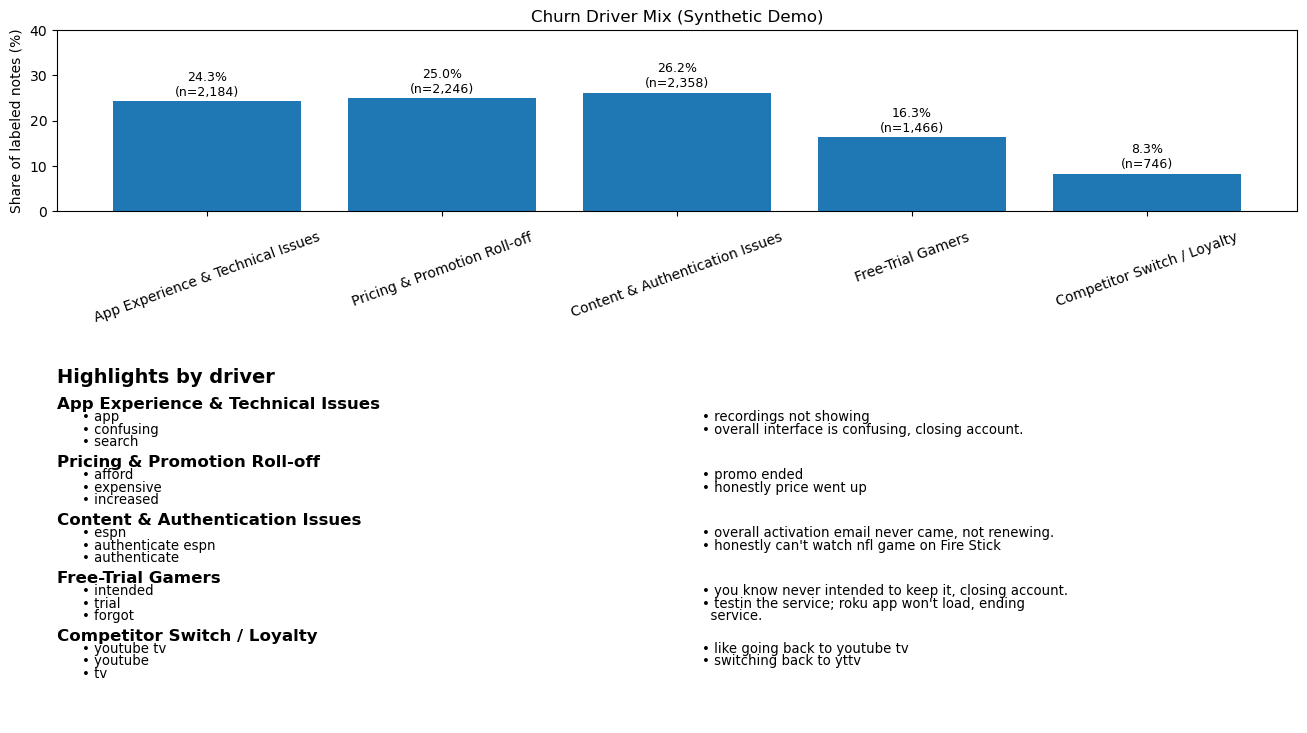

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# --- Inputs ---
label_col = use_label_for_summary  # e.g. "label" or a predicted label column
df_viz = labeled.copy()

order = ["APP_TECH", "PRICING_PROMO", "CONTENT_AUTH", "FREE_TRIAL", "COMPETITOR_LOYALTY"]
display_name = REASON_DISPLAY

# --- Shares ---
counts = df_viz[label_col].value_counts()
total = int(counts.sum())

shares = pd.DataFrame({
    "reason": order,
    "pct": [100.0 * counts.get(r, 0) / max(total, 1) for r in order],
    "n": [int(counts.get(r, 0)) for r in order],
})
shares["reason_name"] = shares["reason"].map(display_name).fillna(shares["reason"])

# --- Helpers: bullets + examples ---
def bullets_for(r: str, k: int = 3):
    return top_phrases.get(r, [])[:k]

def example_for(r: str, k: int = 2):
    return df_viz.loc[df_viz[label_col] == r, "text"].head(k).tolist()

# --- Build table rows (as strings with bullets) ---
rows = []
for r in order:
    b = bullets_for(r, 3)
    ex = example_for(r, 2)
    rows.append({
        "Reason": display_name.get(r, r),
        "Top signals (phrases)": "\n".join([f"• {x}" for x in b]) if b else "—",
        "Example notes": "\n".join([f"• {x}" for x in ex]) if ex else "—",
    })
tbl = pd.DataFrame(rows)

# --- Plot: bar chart + non-overlapping highlights panel ---
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(
    2, 1,
    height_ratios=[1, 2],
    hspace=0.55  # extra separation to keep x-ticks away from the highlights
)

# --------------------
# Top: Bar chart
# --------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(shares["reason_name"], shares["pct"])
ax1.set_title("Churn Driver Mix (Synthetic Demo)")
ax1.set_ylabel("Share of labeled notes (%)")
ax1.set_ylim(0, max(40, float(shares["pct"].max()) * 1.25))
ax1.tick_params(axis="x", rotation=20, pad=10)

# Annotate percent + n
for i, (pct, n) in enumerate(zip(shares["pct"], shares["n"])):
    ax1.text(i, pct + 0.6, f"{pct:.1f}%\n(n={n:,})", ha="center", va="bottom", fontsize=9)

# --------------------
# Bottom: Highlights (layout-safe, no overlap)
# --------------------
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis("off")

# Layout controls (tweak if you want denser/sparser)
left_x = 0.00
mid_x  = 0.52
top_y  = 0.98

title_fs = 14
h_fs = 12
body_fs = 9.5

line_step = 0.035   # vertical step per line (axes coords)
block_gap = 0.020   # extra gap between drivers

wrap_bullets = 34   # wrap width in characters
wrap_examples = 52  # wrap width in characters

def wrap_lines(s: str, width: int):
    """
    Wrap a possibly-multiline bullet string into a list of lines.
    Preserves bullet indentation ("• ") and indents continuation lines.
    """
    lines = []
    for raw in (s or "").split("\n"):
        raw = raw.strip()
        if not raw:
            continue

        prefix = ""
        body = raw
        if raw.startswith("• "):
            prefix = "• "
            body = raw[2:]

        wrapped = textwrap.wrap(body, width=width)
        if not wrapped:
            lines.append(prefix)
        else:
            lines.append(prefix + wrapped[0])
            for cont in wrapped[1:]:
                lines.append("  " + cont)
    return lines

# Title
ax2.text(left_x, top_y, "Highlights by driver", fontsize=title_fs, fontweight="bold", va="top")
y = top_y - 0.08

for _, row in tbl.iterrows():
    reason = row["Reason"]
    bullets = row["Top signals (phrases)"]
    examples_txt = row["Example notes"]

    bullet_lines = wrap_lines(bullets, wrap_bullets)
    example_lines = wrap_lines(examples_txt, wrap_examples)

    # block height = 1 header line + max(content lines across columns)
    header_h = 1
    content_h = max(len(bullet_lines), len(example_lines), 1)
    block_h = (header_h + content_h) * line_step + block_gap

    # Prevent overlap at the bottom: stop gracefully if out of space
    if y - block_h < 0.02:
        ax2.text(left_x, y, "…(additional drivers omitted for layout)", fontsize=10, style="italic", va="top")
        break

    # Header
    ax2.text(left_x, y, reason, fontsize=h_fs, fontweight="bold", va="top")
    y -= line_step

    # Two-column body
    for i in range(content_h):
        if i < len(bullet_lines):
            ax2.text(left_x + 0.02, y - i * line_step, bullet_lines[i], fontsize=body_fs, va="top")
        if i < len(example_lines):
            ax2.text(mid_x, y - i * line_step, example_lines[i], fontsize=body_fs, va="top")

    # Move down for next reason block
    y -= content_h * line_step + block_gap

plt.show()
plt.close()
